In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def get_data_loaders():
    # Data transformations
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load datasets
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=test_transform)

    # Split train into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    return train_loader, val_loader, test_loader

def get_flattened_data():
    # Load original MNIST without augmentation for traditional models
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    # Use same split as for CNN
    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_indices = list(range(train_size))
    val_indices = list(range(train_size, train_size + val_size))

    # Create flattened datasets
    def flatten_dataset(dataset):
        images = []
        labels = []
        for img, label in dataset:
            images.append(img.numpy().flatten())
            labels.append(label)
        return np.array(images), np.array(labels)

    X_train, y_train = flatten_dataset(Subset(full_train, train_indices))
    X_val, y_val = flatten_dataset(Subset(full_train, val_indices))
    X_test, y_test = flatten_dataset(test_dataset)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(14*14*64, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
from tqdm import tqdm


class Config:
    LEARNING_RATE = 0.001
    BATCH_SIZE = 128
    EPOCHS = 5
    PATIENCE = 7
    WEIGHT_DECAY = 1e-4
    STEP_SIZE = 10
    GAMMA = 0.1
    SAVE_DIR = 'checkpoints'
    LOG_DIR = 'logs'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_training():
    os.makedirs(Config.SAVE_DIR, exist_ok=True)
    os.makedirs(Config.LOG_DIR, exist_ok=True)

    train_loader, val_loader, _ = get_data_loaders()
    model = CNN().to(Config.DEVICE)
    optimizer = optim.Adam(model.parameters(),
                           lr=Config.LEARNING_RATE,
                           weight_decay=Config.WEIGHT_DECAY)

    schedulers = {
        'step': StepLR(optimizer, step_size=Config.STEP_SIZE, gamma=Config.GAMMA),
        'plateau': ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    }

    criterion = nn.CrossEntropyLoss()
    log_dir = f'{Config.LOG_DIR}/cnn_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    writer = SummaryWriter(log_dir)

    return model, optimizer, criterion, schedulers, writer, train_loader, val_loader

def train_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0

    with tqdm(train_loader, desc=f'Epoch {epoch}', unit='batch') as pbar:
        for data, target in pbar:
            data, target = data.to(Config.DEVICE), target.to(Config.DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            pbar.set_postfix({
                'loss': total_loss/len(train_loader),
                'acc': 100. * correct/len(train_loader.dataset)
            })

    return total_loss / len(train_loader), 100. * correct / len(train_loader.dataset)

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(Config.DEVICE), target.to(Config.DEVICE)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return val_loss / len(val_loader), 100. * correct / len(val_loader.dataset)

def train_model():
    model, optimizer, criterion, schedulers, writer, train_loader, val_loader = initialize_training()
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, Config.EPOCHS + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Update schedulers
        schedulers['step'].step()
        schedulers['plateau'].step(val_loss)

        # Log metrics
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

        # Save checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{Config.SAVE_DIR}/best_cnn_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= Config.PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

    writer.close()
    return model

if __name__ == "__main__":
    trained_model = train_model()

Epoch 5: 100%|██████████| 375/375 [03:59<00:00,  1.56batch/s, loss=0.341, acc=88.9]


In [ ]:
import time
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib

def train_and_evaluate_models():
    # Load flattened data
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = get_flattened_data()

    print("Training SVM model...")
    start_time = time.time()
    svm = SVC(kernel='rbf', C=10, gamma='scale', verbose=True)
    svm.fit(X_train, y_train)
    svm_train_time = time.time() - start_time

    print("\nTraining KNN model...")
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
    knn.fit(X_train, y_train)
    knn_train_time = time.time() - start_time

    # Evaluate models
    def evaluate_model(model, X, y, name, dataset_name):
        start_time = time.time()
        pred = model.predict(X)
        infer_time = time.time() - start_time
        acc = accuracy_score(y, pred)
        print(f"{name} {dataset_name} Accuracy: {acc:.4f}, Inference Time: {infer_time:.2f}s")
        return pred, acc, infer_time

    print("\nSVM Evaluation:")
    svm_val_pred, svm_val_acc, _ = evaluate_model(svm, X_val, y_val, "SVM", "Validation")
    svm_test_pred, svm_test_acc, _ = evaluate_model(svm, X_test, y_test, "SVM", "Test")

    print("\nKNN Evaluation:")
    knn_val_pred, knn_val_acc, _ = evaluate_model(knn, X_val, y_val, "KNN", "Validation")
    knn_test_pred, knn_test_acc, _ = evaluate_model(knn, X_test, y_test, "KNN", "Test")

    # Save models
    joblib.dump(svm, 'checkpoints/svm_model.pkl')
    joblib.dump(knn, 'checkpoints/knn_model.pkl')

    return {
        'svm': {'model': svm, 'val_pred': svm_val_pred, 'test_pred': svm_test_pred,
                'val_acc': svm_val_acc, 'test_acc': svm_test_acc, 'train_time': svm_train_time},
        'knn': {'model': knn, 'val_pred': knn_val_pred, 'test_pred': knn_test_pred,
                'val_acc': knn_val_acc, 'test_acc': knn_test_acc, 'train_time': knn_train_time}
    }

if __name__ == "__main__":
    models = train_and_evaluate_models()

Training SVM model...
[LibSVM]
Training KNN model...

SVM Evaluation:
SVM Validation Accuracy: 0.9834, Inference Time: 133.44s
SVM Test Accuracy: 0.9828, Inference Time: 111.29s

KNN Evaluation:
KNN Validation Accuracy: 0.9706, Inference Time: 40.47s
KNN Test Accuracy: 0.9670, Inference Time: 35.13s


CNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.95      1.00      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



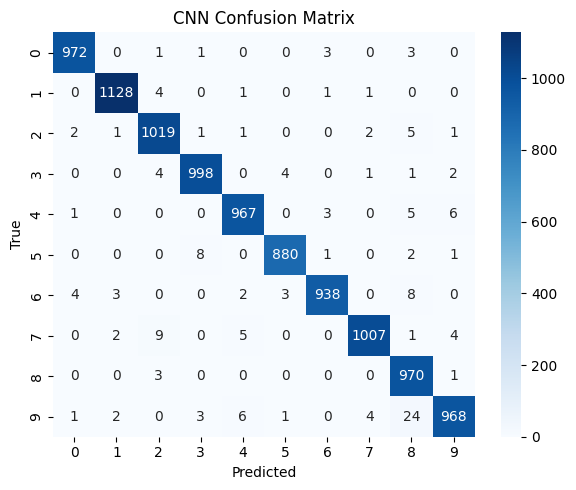


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



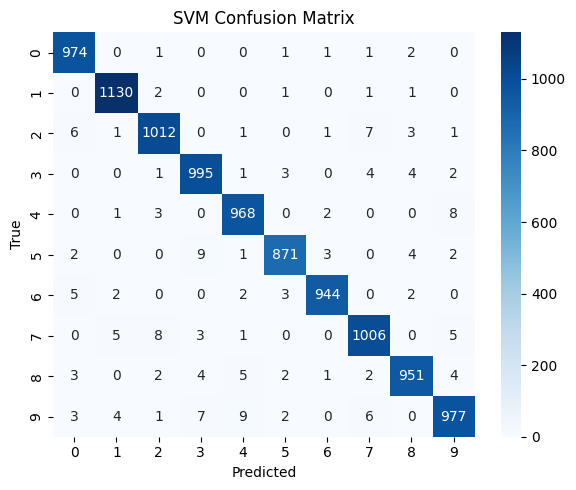


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.95      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.97      0.95      0.96       982
           5       0.96      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



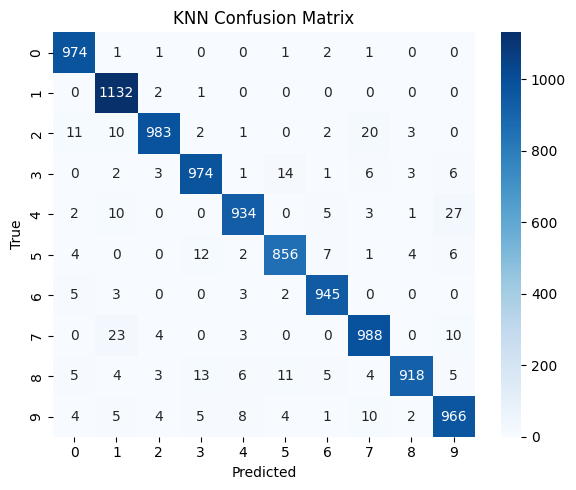


Model Comparison:
CNN Accuracy: 0.9847
SVM Accuracy: 0.9828
KNN Accuracy: 0.9670


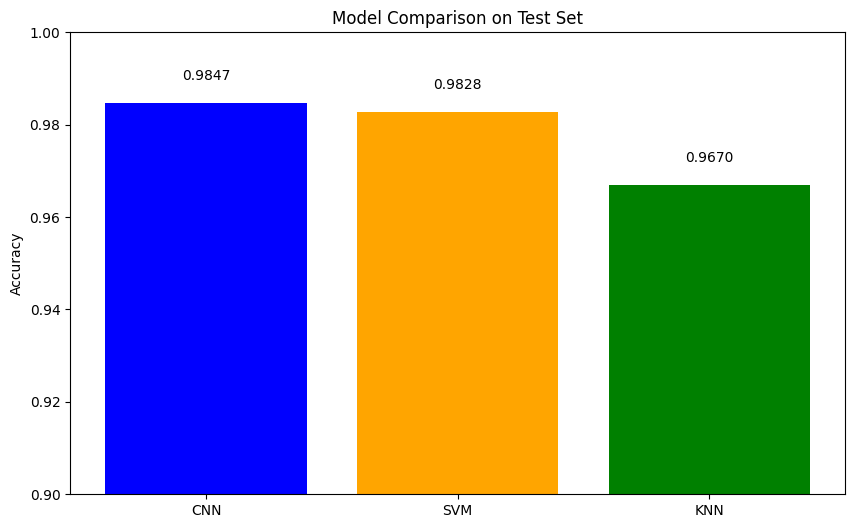

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

def evaluate_cnn(model_path='checkpoints/best_cnn_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    _, _, test_loader = get_data_loaders()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    print("CNN Classification Report:")
    print(classification_report(all_targets, all_preds))

    # Smaller confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))  # Reduced size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 10})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("CNN Confusion Matrix")
    plt.tight_layout()  # Prevent label cutoff
    plt.savefig('cnn_confusion_matrix.png')
    plt.show()

    return all_preds, all_targets

def evaluate_traditional(model_name):
    model = joblib.load(f'checkpoints/{model_name}_model.pkl')
    _, _, (X_test, y_test) = get_flattened_data()

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)

    print(f"\n{model_name.upper()} Classification Report:")
    print(classification_report(y_test, pred))

    # Smaller confusion matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(6, 5))  # Reduced size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 10})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name.upper()} Confusion Matrix")
    plt.tight_layout()  # Prevent label cutoff
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    return pred, y_test

def compare_models():
    cnn_pred, cnn_true = evaluate_cnn()
    svm_pred, svm_true = evaluate_traditional('svm')
    knn_pred, knn_true = evaluate_traditional('knn')

    # Ensure all models evaluated on same test set
    assert all(cnn_true == svm_true) and all(svm_true == knn_true)

    # Compare accuracy
    cnn_acc = accuracy_score(cnn_true, cnn_pred)
    svm_acc = accuracy_score(svm_true, svm_pred)
    knn_acc = accuracy_score(knn_true, knn_pred)

    print("\nModel Comparison:")
    print(f"CNN Accuracy: {cnn_acc:.4f}")
    print(f"SVM Accuracy: {svm_acc:.4f}")
    print(f"KNN Accuracy: {knn_acc:.4f}")

    # Plot accuracy comparison (unchanged size)
    plt.figure(figsize=(10, 6))
    models = ['CNN', 'SVM', 'KNN']
    accuracies = [cnn_acc, svm_acc, knn_acc]
    plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
    plt.ylim(0.9, 1.0)
    plt.ylabel('Accuracy')
    plt.title('Model Comparison on Test Set')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
    plt.savefig('model_comparison.png')
    plt.show()

if __name__ == "__main__":
    compare_models()

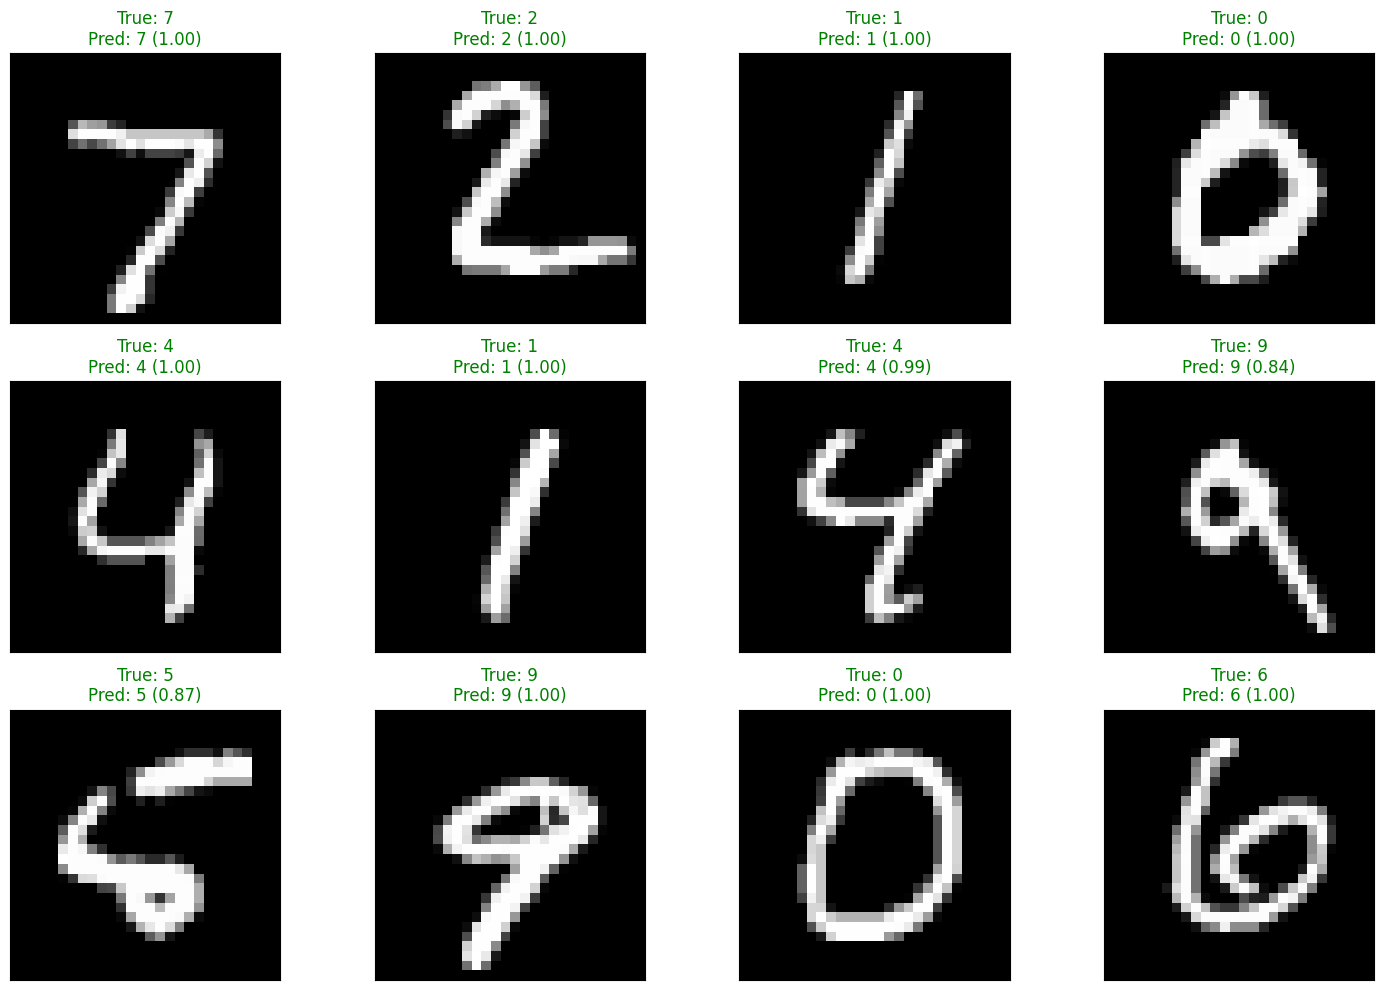

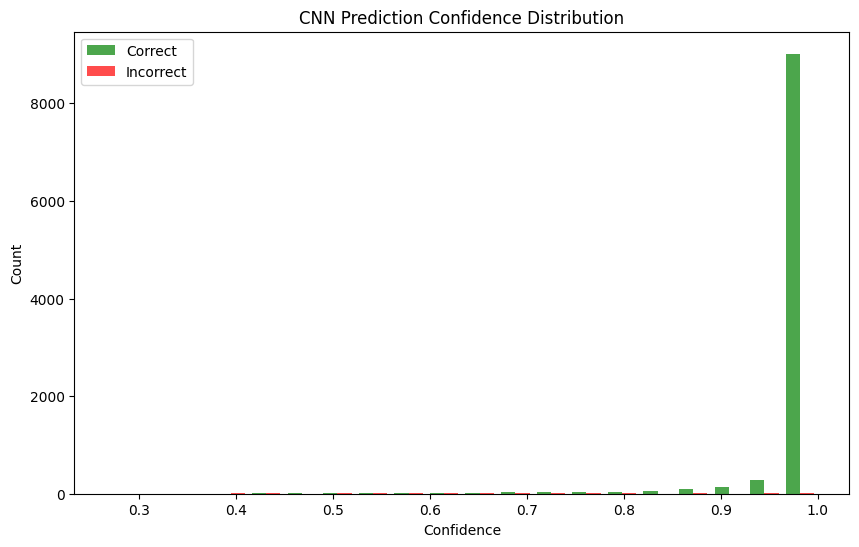

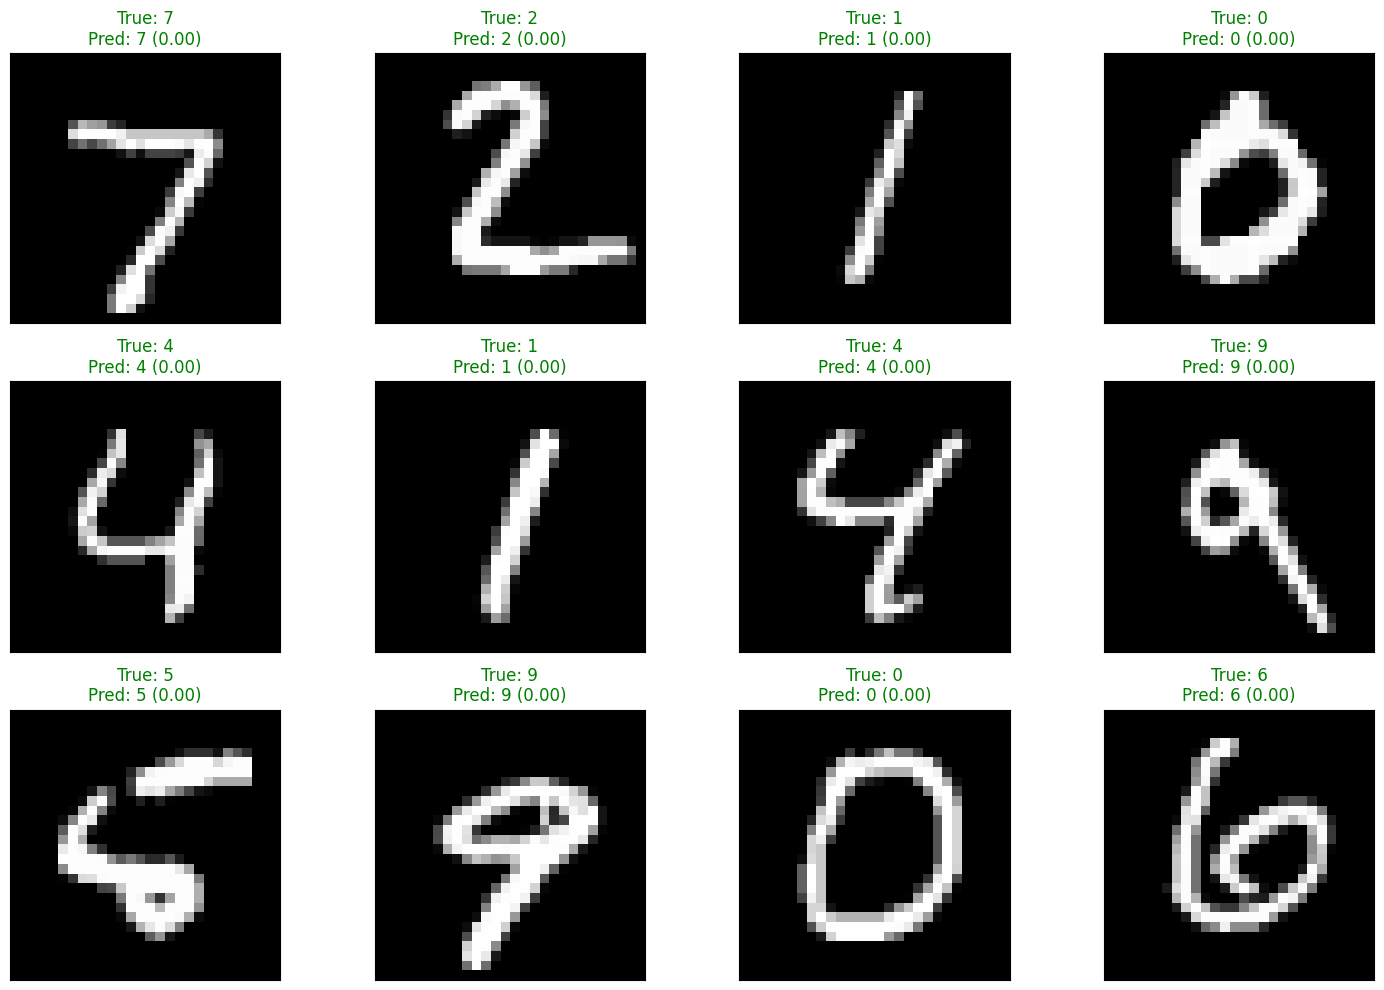

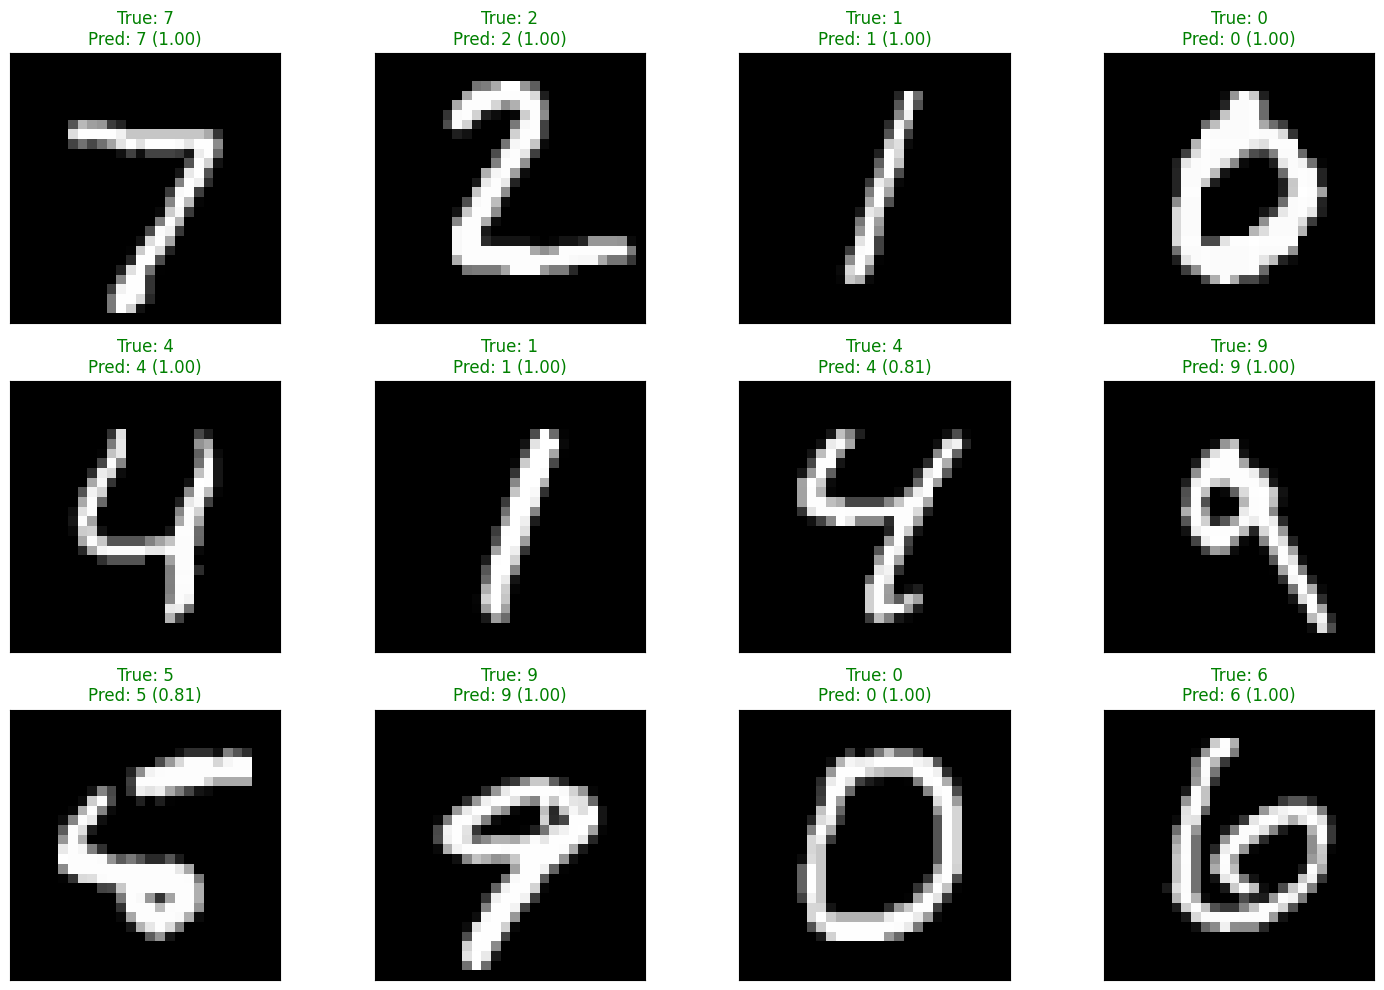

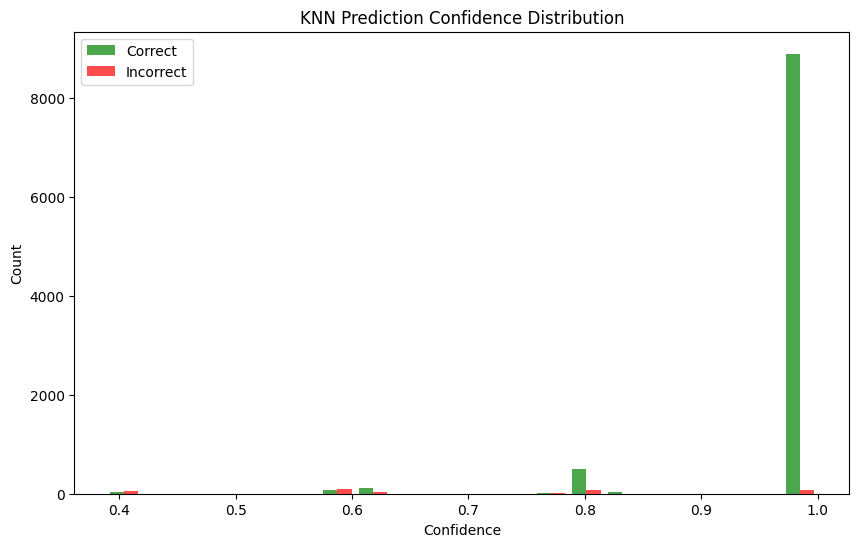

SVM model doesn't have feature importance information.


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
import joblib

def plot_predictions(model_type='cnn', model_path=None, num_images=12):
    _, _, test_loader = get_data_loaders()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_type == 'cnn':
        model = CNN().to(device)
        model.load_state_dict(torch.load(model_path or 'checkpoints/best_cnn_model.pth'))
        model.eval()
    else:
        model = joblib.load(model_path or f'checkpoints/{model_type}_model.pkl')

    fig = plt.figure(figsize=(15, 10))
    images_shown = 0

    for data, target in test_loader:
        for i in range(data.size(0)):
            if images_shown >= num_images:
                break

            img = data[i]
            true_label = target[i].item()

            if model_type == 'cnn':
                img_tensor = img.unsqueeze(0).to(device)
                with torch.no_grad():
                    output = model(img_tensor)
                pred = output.argmax().item()
                prob = torch.nn.functional.softmax(output, dim=1)[0].max().item()
            else:
                img_flat = img.numpy().flatten().reshape(1, -1)
                pred = model.predict(img_flat)[0]
                if hasattr(model, 'predict_proba'):
                    prob = model.predict_proba(img_flat)[0].max()
                else:
                    prob = 0.0

            ax = fig.add_subplot(3, 4, images_shown + 1, xticks=[], yticks=[])
            img_np = img.squeeze().numpy()
            ax.imshow(img_np, cmap='gray')
            title_color = 'green' if pred == true_label else 'red'
            ax.set_title(f"True: {true_label}\nPred: {pred} ({prob:.2f})", color=title_color)
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.savefig(f'{model_type}_predictions.png')
    plt.show()

def plot_confidence_distribution(model_type='cnn', model_path=None):
    _, _, test_loader = get_data_loaders()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_type == 'cnn':
        model = CNN().to(device)
        model.load_state_dict(torch.load(model_path or 'checkpoints/best_cnn_model.pth'))
        model.eval()
    else:
        model = joblib.load(model_path or f'checkpoints/{model_type}_model.pkl')

    confidences = []
    correctness = []

    for data, target in test_loader:
        if model_type == 'cnn':
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            probs = torch.nn.functional.softmax(output, dim=1)
            confidence, preds = torch.max(probs, dim=1)
            confidences.extend(confidence.cpu().numpy())
            correctness.extend(preds.eq(target).cpu().numpy())
        else:
            images = data.numpy().reshape(data.size(0), -1)
            preds = model.predict(images)
            if hasattr(model, 'predict_proba'):
                probs = model.predict_proba(images)
                confidence = np.max(probs, axis=1)
            else:
                confidence = np.zeros(len(preds))  # Placeholder
            confidences.extend(confidence)
            correctness.extend(preds == target.numpy())

    confidences = np.array(confidences)
    correctness = np.array(correctness, dtype=bool)

    plt.figure(figsize=(10, 6))
    plt.hist([confidences[correctness], confidences[~correctness]],
             bins=20, label=['Correct', 'Incorrect'],
             alpha=0.7, color=['green', 'red'])
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title(f'{model_type.upper()} Prediction Confidence Distribution')
    plt.legend()
    plt.savefig(f'{model_type}_confidence_dist.png')
    plt.show()

def plot_feature_importance():
    svm = joblib.load('checkpoints/svm_model.pkl')

    if not hasattr(svm, 'coef_'):
        print("SVM model doesn't have feature importance information.")
        return

    importance = np.abs(svm.coef_[0])

    importance_image = importance.reshape(28, 28)

    plt.figure(figsize=(8, 6))
    plt.imshow(importance_image, cmap='hot')
    plt.colorbar()
    plt.title('SVM Feature Importance')
    plt.savefig('svm_feature_importance.png')
    plt.show()

if __name__ == "__main__":
    for model in ['cnn', 'svm', 'knn']:
        plot_predictions(model)
        if model != 'svm':  # SVM doesn't have reliable confidence scores
            plot_confidence_distribution(model)
    plot_feature_importance()

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your digite.zip file here


Saving digite.zip to digite.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("digite.zip", 'r') as zip_ref:
    zip_ref.extractall("data")  # Extracts to /content/data/digite/


In [ ]:
import os

base_dir = "data/digite"

# Check if the extracted folders exist
if os.path.exists(base_dir):
    print("Extraction successful. Subfolders:")
    print(os.listdir(base_dir))  # Should list ['0', '1', ..., '9']
else:
    print("Extraction failed.")


Extraction successful. Subfolders:
['2', '5', '7', '1', '0', '8', '4', '6', '9', '3']


In [ ]:
import glob

image_paths = glob.glob("data/digite/**/*.*", recursive=True)
print(f"Total images found: {len(image_paths)}")


Total images found: 3230


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='data/digite', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
#my CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Accuracy: 60.02%
Epoch 2, Accuracy: 81.81%
Epoch 3, Accuracy: 88.47%
Epoch 4, Accuracy: 92.96%
Epoch 5, Accuracy: 95.36%
Epoch 6, Accuracy: 96.32%
Epoch 7, Accuracy: 98.45%
Epoch 8, Accuracy: 98.34%
Epoch 9, Accuracy: 99.03%
Epoch 10, Accuracy: 99.54%


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
#my KNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Accuracy: 59.25%
Epoch 2, Accuracy: 81.97%
Epoch 3, Accuracy: 88.74%
Epoch 4, Accuracy: 93.00%
Epoch 5, Accuracy: 94.78%
Epoch 6, Accuracy: 96.52%
Epoch 7, Accuracy: 97.95%
Epoch 8, Accuracy: 98.68%
Epoch 9, Accuracy: 98.65%
Epoch 10, Accuracy: 98.99%


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np

def extract_features(dataset):
    features, labels = [], []
    for img, label in dataset:
        img = img.view(-1).numpy()
        features.append(img)
        labels.append(label)
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_dataset)
X_test, y_test = extract_features(test_dataset)

svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))


SVM Accuracy: 0.7352941176470589


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))


KNN Accuracy: 0.8792569659442725


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 95.98%


In [ ]:
from sklearn.metrics import accuracy_score

# For SVM
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Test Accuracy: {accuracy_svm * 100:.2f}%')

# For KNN
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Test Accuracy: {accuracy_knn * 100:.2f}%')


SVM Test Accuracy: 73.53%
KNN Test Accuracy: 87.93%


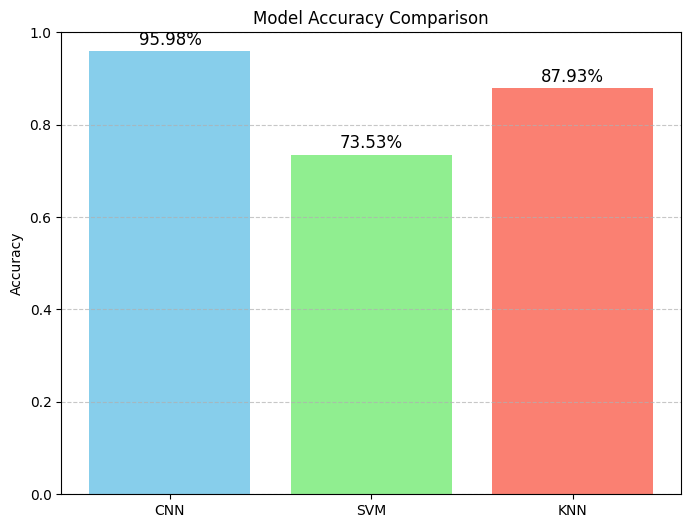

In [ ]:
import matplotlib.pyplot as plt

# Example accuracy values (replace with your real results)
accuracies = {
    'CNN': 0.9598,
    'SVM': 0.7353,
    'KNN': 0.8793,
}

models = list(accuracies.keys())
values = list(accuracies.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(models, values, color=['skyblue', 'lightgreen', 'salmon'])

# Display accuracy values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.2%}', ha='center', va='bottom', fontsize=12)

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


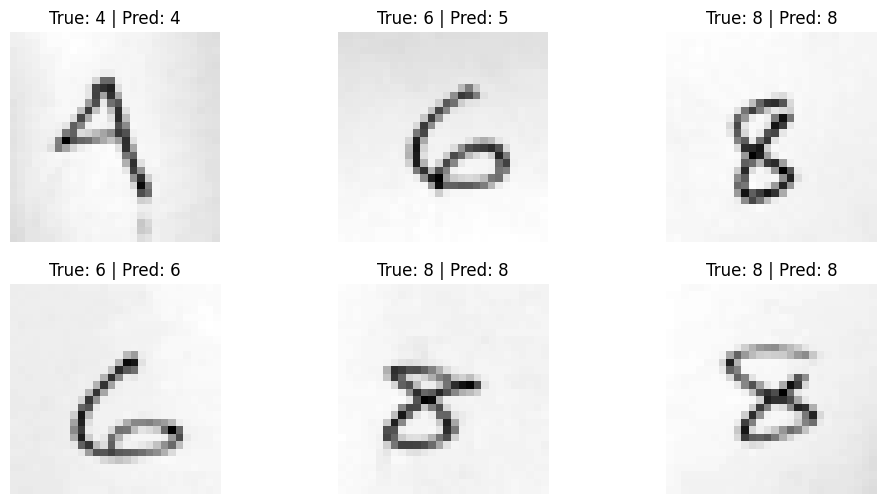

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize if normalized with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.squeeze(npimg), cmap='gray')
    plt.axis('off')

model.eval()
dataiter = iter(test_loader)
# Use the built-in next() function instead of the .next() method
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot first 6 test images with predictions
plt.figure(figsize=(12, 6))
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    imshow(images[idx].cpu())
    plt.title(f'True: {labels[idx].item()} | Pred: {predicted[idx].item()}')
plt.show()

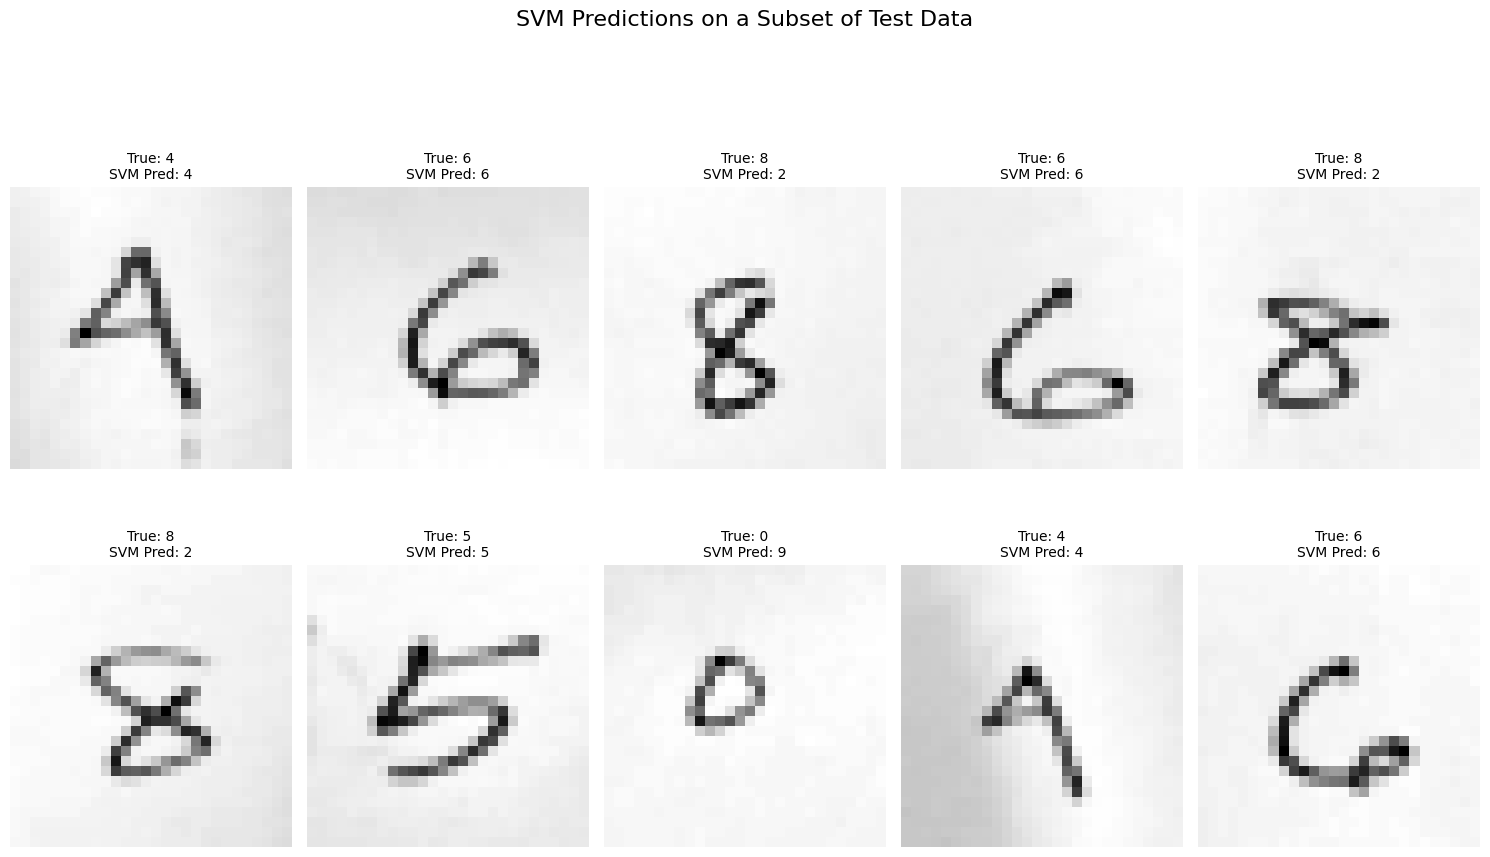

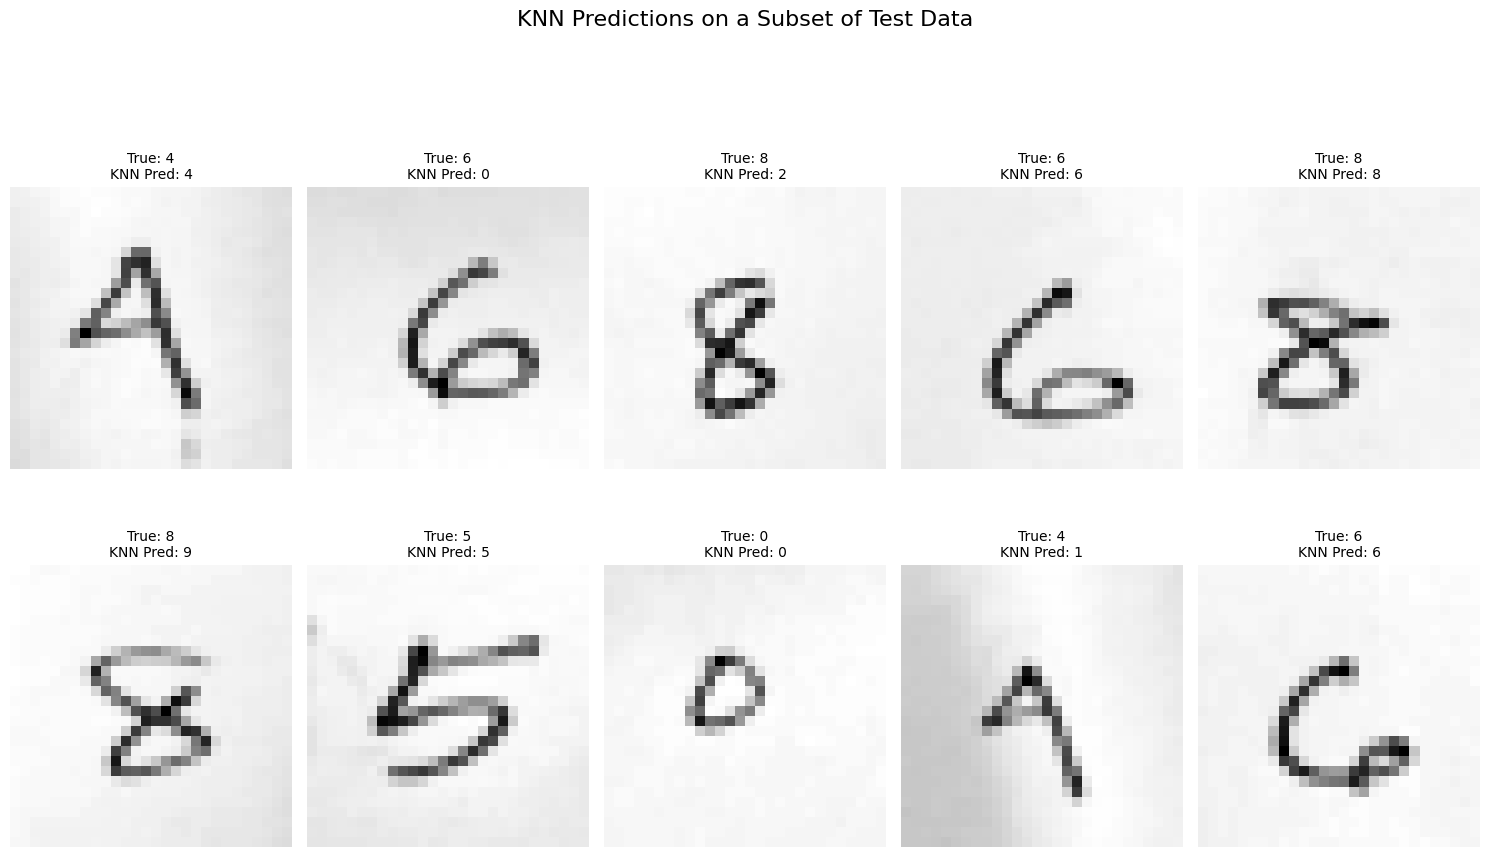

In [ ]:
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
images, labels = next(dataiter)
images_cpu = images.cpu()
labels_cpu = labels.cpu()

# Reshape images for SVM and KNN input (flatten the images)
X_test_subset = images_cpu.view(images_cpu.size(0), -1).numpy()
y_test_subset = labels_cpu.numpy()

# Get predictions from SVM
y_pred_svm_subset = svm_model.predict(X_test_subset)

# Get predictions from KNN
y_pred_knn_subset = knn_model.predict(X_test_subset)

# --- Visualization ---

plt.figure(figsize=(15, 10))

# Visualize results for SVM
for i in range(len(images_cpu)):
    if i >= 10:
        break
    plt.subplot(2, 5, i + 1)
    imshow(images_cpu[i])
    plt.title(f'True: {y_test_subset[i]}\nSVM Pred: {y_pred_svm_subset[i]}', fontsize=10)

plt.suptitle('SVM Predictions on a Subset of Test Data', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(15, 10))

# Visualize results for KNN
for i in range(len(images_cpu)):
    if i >= 10:
        break
    plt.subplot(2, 5, i + 1)
    imshow(images_cpu[i])
    plt.title(f'True: {y_test_subset[i]}\nKNN Pred: {y_pred_knn_subset[i]}', fontsize=10)

plt.suptitle('KNN Predictions on a Subset of Test Data', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
!pip install imgaug


In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install network

  Preparing metadata (setup.py) ... done
  Created wheel for network: filename=network-0.1-py3-none-any.whl size=3138 sha256=2f9132ed7e99cde1162a2030323d0e756e6eb5207a2117a31efc3e60ced6691b
  Stored in directory: /root/.cache/pip/wheels/3a/9a/a4/341d3b109494a43a5cdd444ca83be3a4bfe8c1267ad9f85332
Successfully built network


In [ ]:
!pip install pillow numpy torch torchvision

In [ ]:
# prompt: make a user interface that could recognize hand written number base on cnn knn and svm model that im trained

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import io
import base64
import joblib
from IPython.display import display, HTML, Javascript
from google.colab import output # Import the output module

# Ensure the CNN class is defined (it is defined in a previous cell, but good practice to be aware)
# from .ipynb_checkpoints.ipython-input-2-e34c3408f989 import CNN # Example if in a different file

# Define preprocess_image function (it was used but not defined in the original snippet)
def preprocess_image(data_url):
    """Converts data URL image from canvas to a PyTorch tensor for CNN."""
    header, encoded = data_url.split(",", 1)
    binary = base64.b64decode(encoded)
    image = Image.open(io.BytesIO(binary)).convert('L') # Convert to grayscale
    image = image.resize((28, 28)) # Resize to 28x28
    # Apply the same normalization as the CNN training data
    # MNIST normalization: mean=0.1307, std=0.3081
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    input_tensor = transform(image).unsqueeze(0) # Add batch dimension
    return input_tensor.to(device) # Move to the correct device


# Function to predict using the selected model
def predict_digit_with_model(data_url, model_type):
    # Preprocess image
    # Use the correct preprocessing based on the model type
    if model_type == 'cnn':
        input_tensor = preprocess_image(data_url)
    elif model_type in ['svm', 'knn']:
        # Preprocess for traditional models (flatten and grayscale 0-255)
        header, encoded = data_url.split(",", 1)
        binary = base64.b64decode(encoded)
        image = Image.open(io.BytesIO(binary)).convert('L') # Grayscale
        image = image.resize((28, 28))
        image_array = np.array(image)

        # Re-apply MNIST test normalization for consistency with the flattened data training
        # The flattened data was created by flattening images normalized with (0.1307,), (0.3081,)
        # Need to convert 0-255 to 0-1 first, then normalize.
        image_array_normalized = (image_array / 255.0 - 0.1307) / 0.3081
        input_flat = image_array_normalized.flatten().reshape(1, -1) # Flatten
    else:
        print(f"Unknown model type: {model_type}")
        return


    # Load the appropriate model
    if model_type == 'cnn':
        # Assuming CNN class is defined in a previous cell and accessible
        # If not, you might need to redefine it here or import it.
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loaded_model = CNN().to(device)
        # Ensure the checkpoint path is correct
        try:
            loaded_model.load_state_dict(torch.load('checkpoints/best_cnn_model.pth', map_location=device))
        except FileNotFoundError:
            display(Javascript("document.getElementById('result').innerText = 'Error: CNN model checkpoint not found!';"))
            print("Error: CNN model checkpoint not found at 'checkpoints/best_cnn_model.pth'")
            return
        except Exception as e:
             display(Javascript(f"document.getElementById('result').innerText = 'Error loading CNN model: {e}';"))
             print(f"Error loading CNN model: {e}")
             return

        loaded_model.eval()
        with torch.no_grad():
            output_tensor = loaded_model(input_tensor) # Use input_tensor for CNN
            probabilities = F.softmax(output_tensor, dim=1)[0].cpu().numpy()
            prediction = output_tensor.argmax().item()

    elif model_type in ['svm', 'knn']:
        try:
            loaded_model = joblib.load(f'checkpoints/{model_type}_model.pkl')
        except FileNotFoundError:
             display(Javascript(f"document.getElementById('result').innerText = 'Error: {model_type.upper()} model checkpoint not found!';"))
             print(f"Error: {model_type.upper()} model checkpoint not found at 'checkpoints/{model_type}_model.pkl'")
             return
        except Exception as e:
             display(Javascript(f"document.getElementById('result').innerText = 'Error loading {model_type.upper()} model: {e}';"))
             print(f"Error loading {model_type.upper()} model: {e}")
             return

        prediction = loaded_model.predict(input_flat)[0] # Use input_flat for SVM/KNN

        # Get probabilities if the model supports it
        if hasattr(loaded_model, 'predict_proba'):
             probabilities = loaded_model.predict_proba(input_flat)[0]
        else:
             probabilities = np.zeros(10) # No probabilities for this model type unless it supports predict_proba


    # Display result
    display(Javascript(f"""
        document.getElementById('result').innerText = 'Predicted by {model_type.upper()}: {prediction}';
    """))

    # Display probability distribution (only for models that provide probabilities)
    if np.any(probabilities): # Check if there are any non-zero probabilities
        fig, ax = plt.subplots(figsize=(10, 3))
        bars = ax.bar(range(10), probabilities, color='#2196F3')
        if prediction is not None and 0 <= prediction < 10:
             bars[prediction].set_color('#4CAF50')
        ax.set_xlabel('Digits')
        ax.set_ylabel('Probability')
        ax.set_title(f'{model_type.upper()} Prediction Probabilities')
        ax.set_xticks(range(10))
        ax.set_ylim(0, 1.05) # Adjust y-limit slightly
        ax.text(prediction, probabilities[prediction] + 0.02, f"{probabilities[prediction]:.2f}", ha='center', va='bottom', color='black', fontsize=10)


        # Save to buffer and convert to base64
        buf = io.Bytes.BytesIO() # Use BytesIO from io
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig) # Close the figure to free up memory

        display(Javascript(f"""
            document.getElementById('probabilities').innerHTML =
                '<img src="data:image/png;base64,{img_str}" style="width:100%; border-radius:8px; box-shadow:0 4px 8px rgba(0,0,0,0.1)">';
        """))
    else:
         display(Javascript(f"""
             document.getElementById('probabilities').innerHTML = '<p style="text-align:center; color:gray;">Probability distribution not available or could not be computed for {model_type.upper()}</p>';
         """))

# Define the load_random_test_image function (used in the HTML but not defined)
def load_random_test_image():
    """Loads a random image from the test set onto the canvas."""
    _, _, test_loader = get_data_loaders() # Assuming get_data_loaders is defined
    device = torch.device("cpu") # Load to CPU for displaying on canvas

    # Get a random batch and a random image from that batch
    images, labels = next(iter(test_loader))
    random_idx = np.random.randint(0, images.size(0))
    random_image = images[random_idx]
    true_label = labels[random_idx].item()

    # Unnormalize the image for display
    # MNIST normalization: (image - 0.1307) / 0.3081 -> image * 0.3081 + 0.1307
    unnormalize = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))
    random_image_unnormalized = unnormalize(random_image)


    # Convert to PIL Image, then to a data URL
    img_pil = transforms.ToPILImage()(random_image_unnormalized.squeeze(0)) # Squeeze channel dim
    buf = io.BytesIO()
    img_pil.save(buf, format='PNG')
    img_data_url = 'data:image/png;base64,' + base64.b64encode(buf.getvalue()).decode('utf-8')


    # Use Javascript to draw the image on the canvas
    display(Javascript(f"""
        const canvas = document.getElementById('canvas');
        const ctx = canvas.getContext('2d');
        const img = new Image();
        img.onload = function() {{
            ctx.fillStyle = "black"; // Clear with black background first
            ctx.fillRect(0, 0, canvas.width, canvas.height);
            // Draw the image scaled to fit the canvas
            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);
        }};
        img.src = '{img_data_url}';
        document.getElementById('result').innerText = 'True Label: {true_label}';
        document.getElementById('probabilities').innerHTML = ''; // Clear previous probabilities
    """))


# Register callback functions for each model type
output.register_callback('predict_digit_cnn', lambda data_url: predict_digit_with_model(data_url, 'cnn'))
output.register_callback('predict_digit_svm', lambda data_url: predict_digit_with_model(data_url, 'svm'))
output.register_callback('predict_digit_knn', lambda data_url: predict_digit_with_model(data_url, 'knn'))
# Register the new callback for the random test button
output.register_callback('load_random_test_image', load_random_test_image)


# Update the HTML UI to include buttons for each model
display(HTML("""
<div style="display: flex; flex-direction: column; align-items: center;">
  <h2>Handwritten Digit Recognition</h2>
  <div style="position: relative;">
    <canvas id="canvas" width="280" height="280" style="border: 2px solid #333; background: black; border-radius: 8px; cursor: crosshair;"></canvas>
    <button id="clearBtn" style="position: absolute; top: 10px; right: 10px; padding: 8px 16px; background: #ff4d4d; color: white; border: none; border-radius: 4px; cursor: pointer;">Clear</button>
  </div>
  <div style="margin-top: 20px; display: flex; gap: 10px; flex-wrap: wrap; justify-content: center;">
    <button id="predictCnnBtn" style="padding: 12px 18px; background: #4CAF50; color: white; border: none; border-radius: 4px; font-size: 14px; cursor: pointer;">Recognize (CNN)</button>
    <button id="predictSvmBtn" style="padding: 12px 18px; background: #FFA500; color: white; border: none; border-radius: 4px; font-size: 14px; cursor: pointer;">Recognize (SVM)</button>
    <button id="predictKnnBtn" style="padding: 12px 18px; background: #007bff; color: white; border: none; border-radius: 4px; font-size: 14px; cursor: pointer;">Recognize (KNN)</button>
    <button id="randomBtn" style="padding: 12px 18px; background: #2196F3; color: white; border: none; border-radius: 4px; font-size: 14px; cursor: pointer;">Load Random Test</button>
  </div>
  <div id="result" style="margin-top: 30px; font-size: 28px; font-weight: bold; min-height: 36px; text-align: center;"></div>
  <div id="probabilities" style="margin-top: 20px; width: 100%; max-width: 500px;"></div>
</div>

<script>
const canvas = document.getElementById('canvas');
const ctx = canvas.getContext('2d');
let drawing = false;

// Initialize with black background
ctx.fillStyle = 'black';
ctx.fillRect(0, 0, canvas.width, canvas.height);

// Set drawing styles - WHITE DIGITS on BLACK BACKGROUND
ctx.lineWidth = 18;
ctx.lineCap = 'round';
ctx.strokeStyle = '#fff';  // WHITE drawing color

// Mouse event handlers
canvas.addEventListener('mousedown', startDrawing);
canvas.addEventListener('mousemove', draw);
canvas.addEventListener('mouseup', stopDrawing);
canvas.addEventListener('mouseout', stopDrawing);

// Touch event handlers for mobile
canvas.addEventListener('touchstart', handleTouch);
canvas.addEventListener('touchmove', handleTouch);
canvas.addEventListener('touchend', stopDrawing);

function handleTouch(e) {
  e.preventDefault();
  const touch = e.touches[0];
  const rect = canvas.getBoundingClientRect();
  const mouseEvent = new MouseEvent('mousedown', {
    clientX: touch.clientX,
    clientY: touch.clientY
  });
  canvas.dispatchEvent(mouseEvent);
}


function startDrawing(e) {
  drawing = true;
  const rect = canvas.getBoundingClientRect();
  const x = (e.clientX - rect.left) * (canvas.width / rect.width);
  const y = (e.clientY - rect.top) * (canvas.height / rect.height);
  ctx.beginPath(); // Start a new path for each stroke
  ctx.moveTo(x, y);
}

function draw(e) {
  if (!drawing) return;

  const rect = canvas.getBoundingClientRect();
  const x = (e.clientX - rect.left) * (canvas.width / rect.width);
  const y = (e.clientY - rect.top) * (canvas.height / rect.height);

  ctx.lineTo(x, y);
  ctx.stroke();
  //ctx.beginPath(); // Do not begin new path here, continue the stroke
  //ctx.moveTo(x, y); // Do not move here, keep drawing
}

function stopDrawing() {
  drawing = false;
  ctx.beginPath(); // Start a new path for the next stroke
}

// Clear canvas - reset to BLACK background
document.getElementById('clearBtn').addEventListener('click', function() {
  ctx.fillStyle = "black";
  ctx.fillRect(0, 0, canvas.width, canvas.height);
  document.getElementById('result').innerText = '';
  document.getElementById('probabilities').innerHTML = '';
});

// Predict buttons
document.getElementById('predictCnnBtn').addEventListener('click', function() {
  const dataURL = canvas.toDataURL('image/png');
  google.colab.kernel.invokeFunction('predict_digit_cnn', [dataURL], {});
});

document.getElementById('predictSvmBtn').addEventListener('click', function() {
  const dataURL = canvas.toDataURL('image/png');
  google.colab.kernel.invokeFunction('predict_digit_svm', [dataURL], {});
});

document.getElementById('predictKnnBtn').addEventListener('click', function() {
  const dataURL = canvas.toDataURL('image/png');
  google.colab.kernel.invokeFunction('predict_digit_knn', [dataURL], {});
});


// Random test button
document.getElementById('randomBtn').addEventListener('click', function() {
  google.colab.kernel.invokeFunction('load_random_test_image', [], {});
});
</script>

<style>
  body { font-family: 'Arial', sans-serif; }
  button { transition: all 0.3s; }
  button:hover { transform: translateY(-2px); box-shadow: 0 4px 8px rgba(0,0,0,0.1); }
  button:active { transform: translateY(0); }
  #result { color: #333; }
</style>
"""))